# Time Domain   and Gating

## Intro

* This notebooks demonstrates how to use [scikit-rf](www.scikit-rf.org) for time-domain analysis and gating. 
* S-parameters are measured in the frequency domain, but can be analyzed in  time domain.
* A major application of time-domain analysis is to use *gating* to isolate a single response in space.
* WARNING: Gating is not de-embedding!


More information about the details of time domain analysis see [1]. 


References

* [1] Keysight - Time Domain Analysis Using a Network Analyzer - Application Note [pdf](https://www.keysight.com/us/en/assets/7018-01451/application-notes/5989-5723.pdf)

## Quick Example

<img src="figures/probe.svg" width="600">

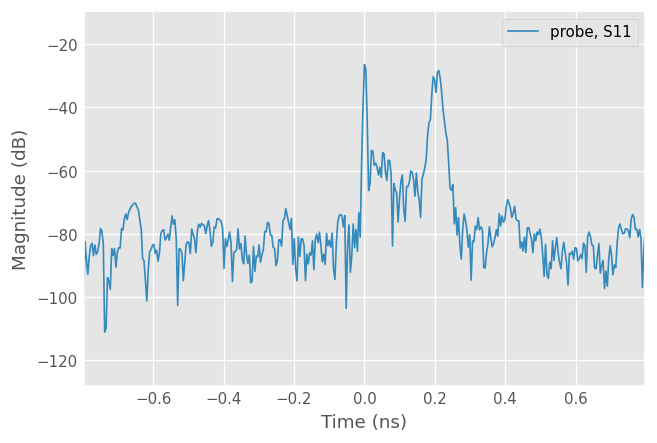

In [4]:
%matplotlib inline
import skrf as rf 
from pylab import * 
rf.stylely()

# load data for the waveguide to CPW probe
probe = rf.Network('data/calibration/oneport_tiered_calibration/probe.s2p')
s11 = probe.s11 
s11.plot_s_db_time()

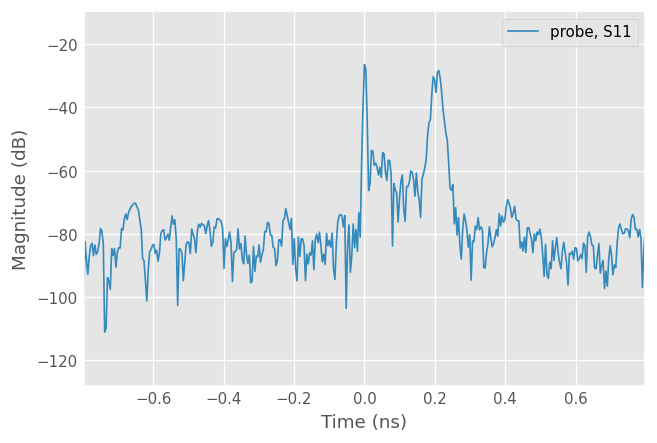

In [7]:
s11.plot_s_db_time()

In [8]:
#  time-gate the first largest reflection
s11_gated = s11.time_gate(center=0, span=.2)
s11_gated.name='gated probe'

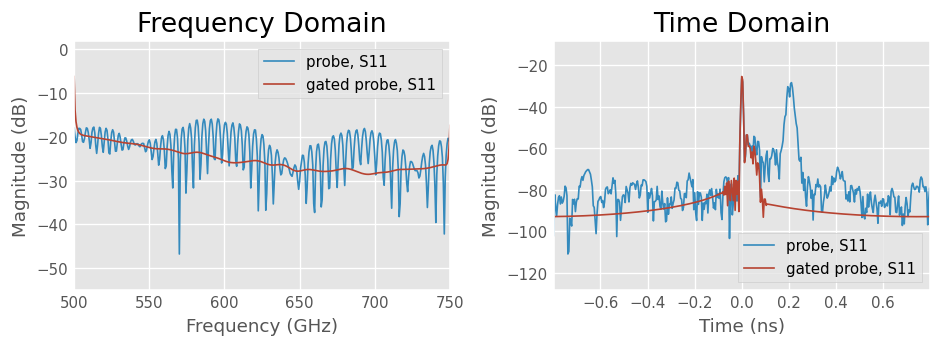

In [10]:
# plot frequency and time-domain s-parameters
fig=figure(figsize=(8,3)) 
subplot(121)
s11.plot_s_db()
s11_gated.plot_s_db()
title('Frequency Domain')

subplot(122)
s11.plot_s_db_time()
s11_gated.plot_s_db_time()
title('Time Domain')
tight_layout()

## Interpreting Time Domain



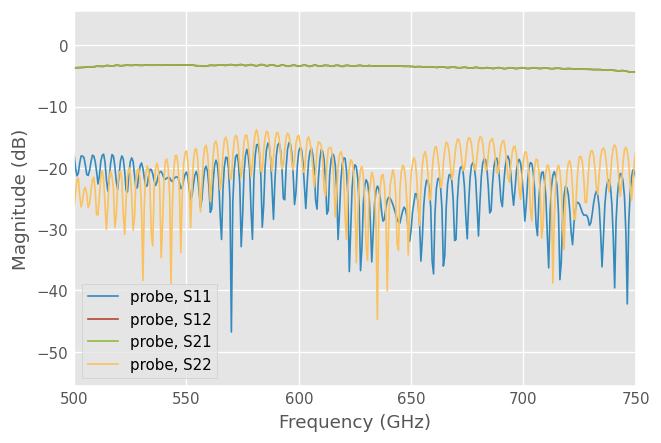

In [11]:
# load data for the waveguide to CPW probe
probe = rf.Network('data/calibration/oneport_tiered_calibration/probe.s2p')
probe.plot_s_db()

* Note there are two  time-domain plotting functions in scikit-rf: 

    * `Network.plot_s_db_time()`  
    * `Network.plot_s_time_db()`

*  `plot_s_db_time()` employs windowing  to enhance impulse resolution. 
* Windowing will be discussed in a bit, but for now we just use `plot_s_db_time()`.
* Plotting all four s-parameters of the probe in both frequency and time-domain.

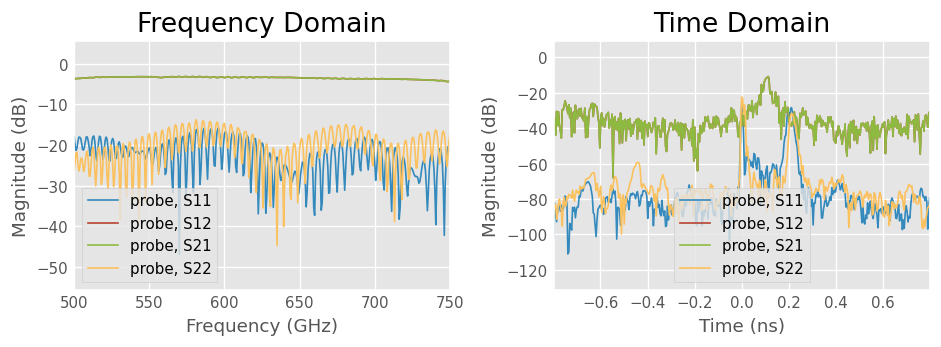

In [12]:
# plot frequency and time-domain s-parameters
figure(figsize=(8,3))
subplot(121)
probe.plot_s_db()
title('Frequency Domain')  
subplot(122)
probe.plot_s_db_time()
title('Time Domain')
tight_layout()

### Port 1 
Focusing on  the reflection coefficient from the waveguide port (s11), you can see there is an interference pattern present.

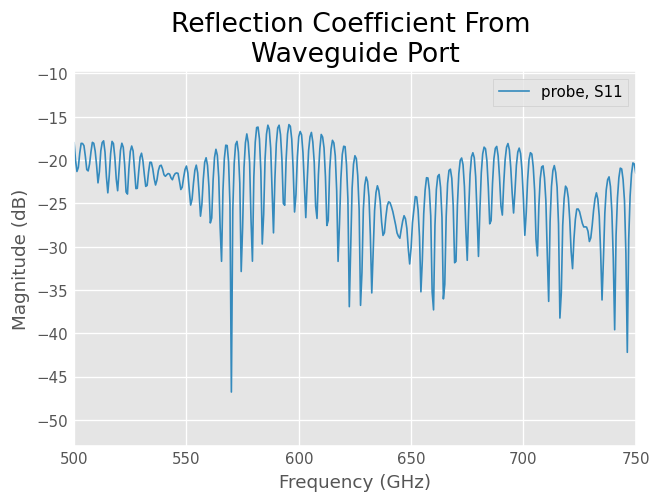

In [13]:
probe.plot_s_db(0,0)
title('Reflection Coefficient From \nWaveguide Port');

* This ripple is an evidence of several discrete reflections. 
* Plotting s11 in the time-domain allows us to see where, or *when*, these reflections occur.

(-100.0, 0.0)

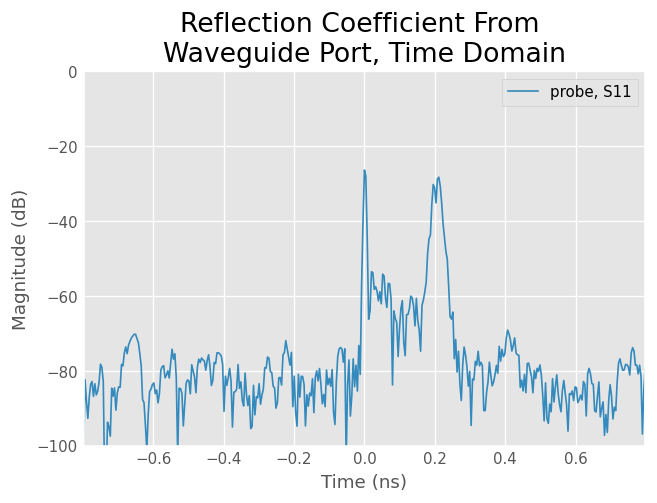

In [18]:
probe_s11 = probe.s11
probe_s11.plot_s_db_time(0,0)
title('Reflection Coefficient From \nWaveguide Port, Time Domain')
ylim(-100,0)

(-100.0, 0.0)

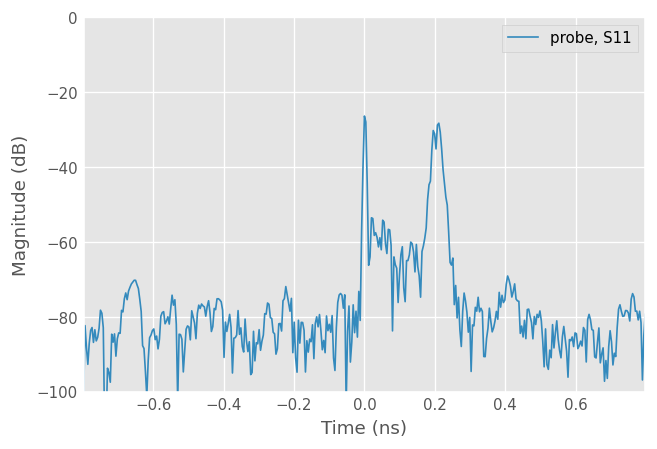

In [21]:
probe_s11.plot_s_db_time(0,0)
ylim(-100,0)

From this plot we can see two dominant reflections; 

* one at $t=0$ ns (the test-port) 
* and another  at $t=.2$ ns (who knows?).

Now to gating..


## Gating The Reflection of Interest

* To isolate the reflection from the waveguide port, we can use time-gating. 
* This can be done by using the method `Network.time_gate()`, 
   * provide it an appropriate center and span (in ns). 
* To see the effects of the gate, both the original and gated response are compared.

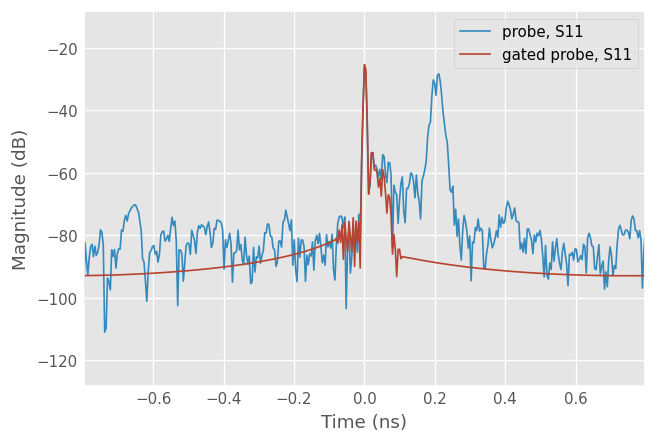

In [22]:
probe_s11_gated = probe_s11.time_gate(center=0, span=.2)
probe_s11_gated.name='gated probe'

s11.plot_s_db_time()
s11_gated.plot_s_db_time()

Compare both responses in frequency domain to see the effect of the gate. 

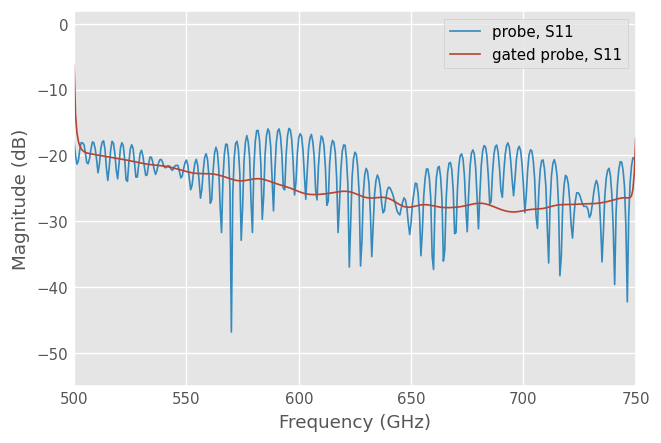

In [23]:
s11.plot_s_db()
s11_gated.plot_s_db()

###  Auto-gate 

The time-gating method in `skrf` has an auto-gating feature which can also be used to gate the largest reflection. 

When no gate parameters are provided, `time_gate()` does the following: 

1. find the two largest peaks
2. center the gate on the tallest peak
3. set span to distance between two tallest peaks

You may want to plot the gated network in time-domain to see what the determined gate shape looks like.

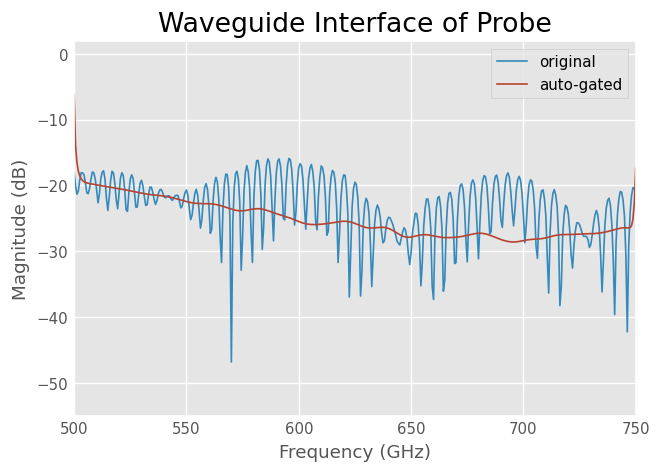

In [24]:
title('Waveguide Interface of Probe') 
s11.plot_s_db(label='original')
s11.time_gate().plot_s_db(label='auto-gated') #autogate on the fly

Might see how the autogate does on the other probe interface, 

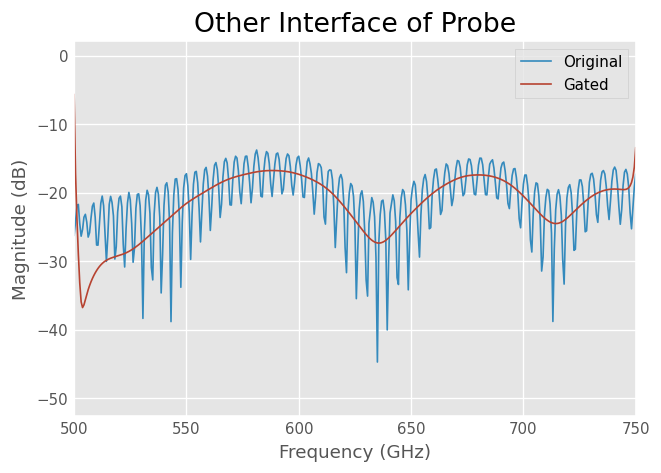

In [26]:
title('Other Interface of Probe') 
probe.s22.plot_s_db(label='Original')
probe.s22.time_gate().plot_s_db(label='Gated')

## Determining Distance

* To make time-domain useful as a diagnostic tool, one would like to convert the x-axis to distance.
* This requires knowledge of the propagation velocity in the device.  
* **skrf** provides some transmission-line models in the module [skrf.media](http://scikit-rf.readthedocs.org/en/latest/reference/media/index.html), which  can be used for this.

**However... DISCLAIMER**

* For dispersive media, such as rectangular waveguide, the phase velocity is a function of frequency.
* And transforming time to distance is not straightforward.
* As an approximation, you can normalize the x-axis to the speed of light.
* Alternatively, you can simulate the a known device and compare the two time domain responses.
* This allows you to attribute quantitative meaning to the axes. 

Example


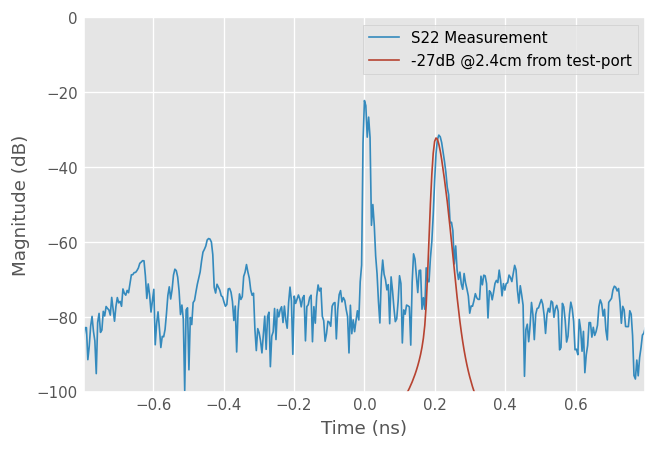

In [29]:
from skrf.media import RectangularWaveguide
# create a rectangular waveguide media to generate a theoretical network
wr1p5 = RectangularWaveguide(frequency=probe.frequency, a=15*rf.mil, z0=1) 
# adjust  an ideal delayed load until agreement
G = -27
kw = dict(d=2.4, unit='cm', Gamma0=rf.db_2_mag(G))
theory = wr1p5.delay_load(**kw)
probe.s22.plot_s_db_time(label = 'S22 Measurement')
theory.plot_s_db_time(label='{G}dB @{d}{unit} from test-port'.format(**kw, G=G))
ylim(-100, 0);
fig=gcf()

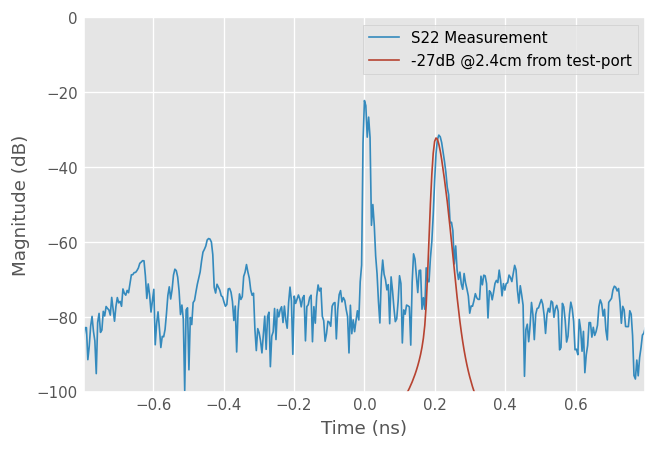

In [30]:
fig

This plot demonstrates a few important points:

* the theoretical delayed load is not a perfect impulse in time. This is due to the dispersion in waveguide. 
* the peak of the magnitude in time domain is not identical to that specified, also due to dispersion (and windowing).

 

## What the hell is Windowing?

The `'plot_s_db_time()'` function does a few things. 

1. Windows the s-parameters. 
2. Converts to time domain  
3. Takes magnitude component, convert to dB
4. Calculates time-axis s
5. Plots

### windowing
* A FFT represents a signal with a basis of periodic signals (sinusoids).  
* If your frequency response is not periodic, a FFT  will introduces artifacts in the time-domain results. 
* To minimize these effects, the frequency response is *windowed*. 
* This makes the frequency response more periodic by tapering off the band-edges. 
* Windowing is just applied to improve the plot appearance, it does not affect the original network.

In skrf this can be done explicitly using the `'windowed()'` function.  
By default this function uses the _Hamming_ window, but can be adjusted through arguments. 

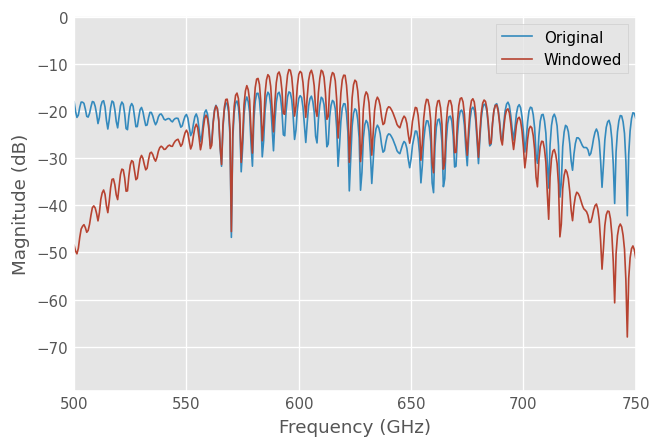

In [31]:
probe_w = probe.windowed()
probe.plot_s_db(0,0, label = 'Original')
probe_w.plot_s_db(0,0, label = 'Windowed')


Comparing the two time-domain plotting functions, we can see the difference between windowed  and not. 

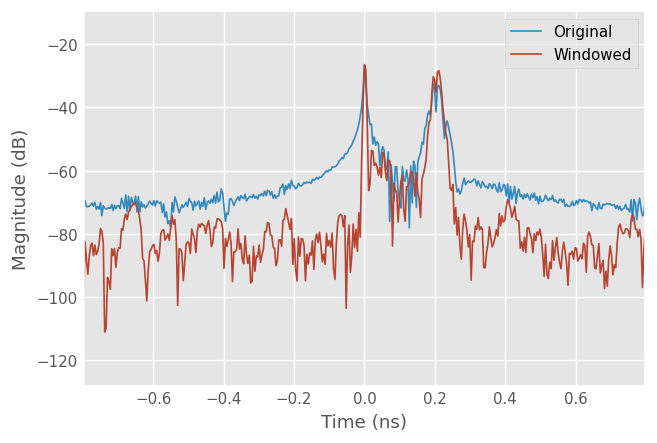

In [34]:
probe.plot_s_time_db(0,0, label = 'Original')
probe_w.plot_s_time_db(0,0, label = 'Windowed')